# Portfolio Optimization using Eigenvalue Decomposition

In this project, we assign weights to different tickers using the normalised largest set of eigenvalues from the covariance matrix of the log returns of the stocks

Let us begin.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from functions import *
import seaborn as sns

Here, I have chosen a couple of random tech and medical company stocks and have downloaded them alongside the S&P 500 data as well as the 10 Year US Treasury Rate to use as the risk free rate

In [2]:

Tickers = ["AAPL","MSFT","AMZN","GOOG","FB","TSLA",
            "BABA","NVDA","INTC","CRM","AMD","BIO",
            "BIIB","CVS","PODD","HZNP","QDEL"]

Stocks = yf.download(tickers=Tickers, start="2015-01-01",
                    end="2020-12-31", progress=True, 
                     auto_adjust=True)["Close"]

SP500 = yf.download(tickers="^GSPC", start="2015-01-01",
                    end="2020-12-31", progress=True,
                    auto_adjust=True)["Close"]

TS03 = yf.download(tickers="^IRX", start="2015-01-01",
                    end="2020-12-31", progress=True,
                    auto_adjust=True)["Close"] / 100



StocksNormal = (Stocks - Stocks.mean()) / Stocks.std()
SP500Normal = (SP500 - SP500.mean()) / SP500.std()
StocksLogReturns = np.log(Stocks / Stocks.shift(1))[1:]
SP500LogReturns = np.log(SP500 / SP500.shift(1))[1:]

testStocks = StocksLogReturns[int(len(Stocks)*0.3):]
testIndex = SP500LogReturns[int(len(Stocks)*0.3):]
testTS = TS03[int(len(Stocks)*0.3):]


[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


I find the Log Returns of each stock and store it as a multivariate time-series dataframe

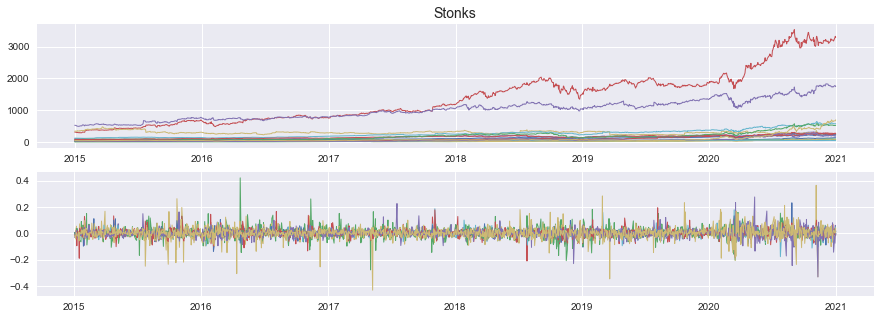

In [3]:

fig, axes = plt.subplots(2, 1)
axes[0].plot(Stocks)
axes[0].set_title("Stonks", size=14)
axes[1].plot(StocksLogReturns)
plt.show()


In [4]:

StocksCov = StocksLogReturns[:int(len(Stocks)*0.3)].corr()
D, S = np.linalg.eigh(StocksCov)
Eigenportfolio = S[:, -1] / np.sum(S[:, -1])  # Normalize to sum to 1
EigenportfolioLargest = pd.DataFrame(
                    data=Eigenportfolio,
                    columns=["Investment Weight"],
                    index=list(StocksLogReturns.columns))


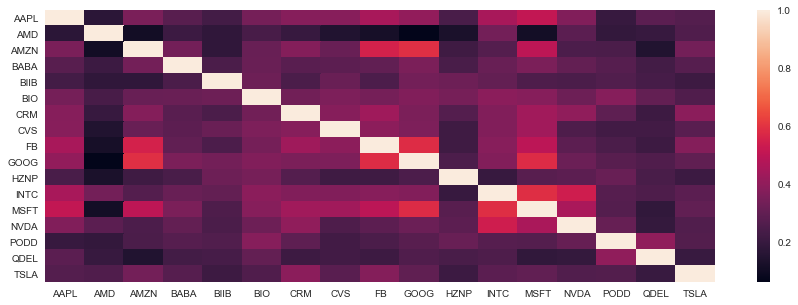

In [5]:
sns.heatmap(StocksCov);

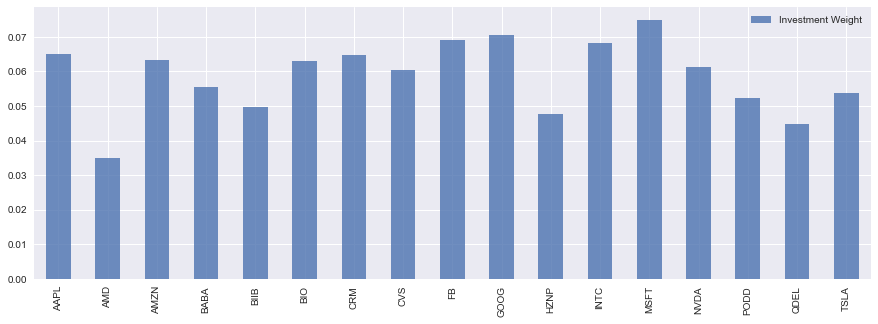

In [6]:
EigenportfolioLargest.plot(kind="bar", alpha=0.8);

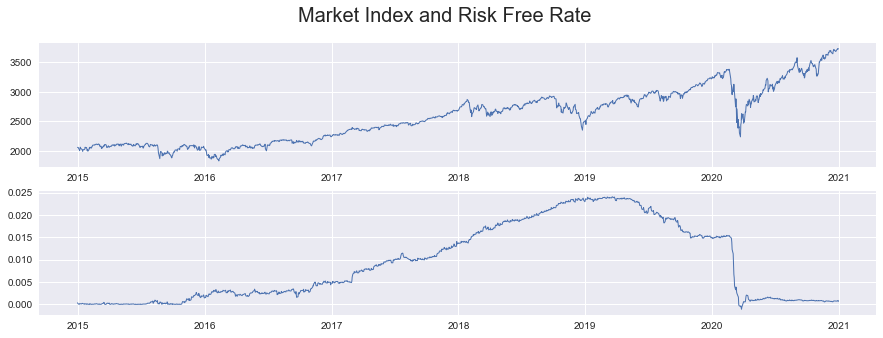

In [7]:

fig, axes = plt.subplots(2)
axes[0].plot(SP500)
axes[1].plot(TS03)
fig.suptitle("Market Index and Risk Free Rate", size=20)
plt.show()


In [8]:

portfolioData = np.dot(testStocks.values, EigenportfolioLargest.values)
portfolioReturns = pd.DataFrame(
    data=portfolioData.cumsum() * 100,
    index=testStocks.index,
    columns=["Portfolio Returns"],
)


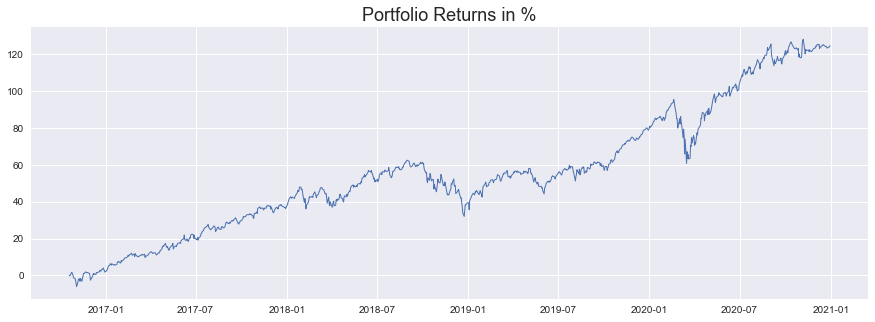

In [9]:

plt.plot(portfolioReturns)
plt.title("Portfolio Returns in %", size=18)
plt.show()


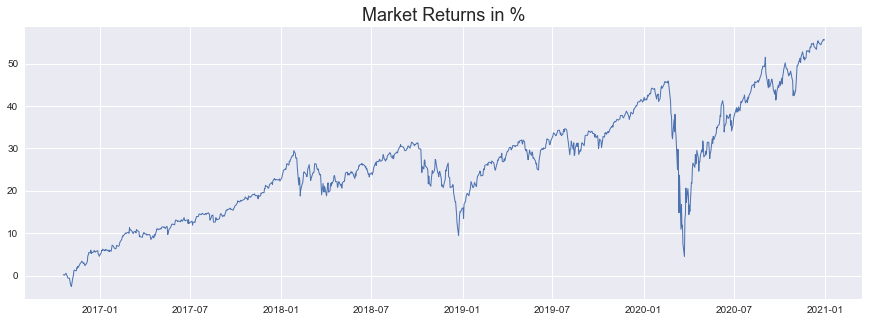

In [10]:

marketReturnsCumsum = testIndex.cumsum() * 100
plt.plot(marketReturnsCumsum, label="Market Returns")
plt.title("Market Returns in %", size=18)
plt.show()


In [11]:

ExcessReturnsofPortfolio = np.subtract(portfolioData[11:].T, testTS.values)[0]
ExcessReturnsofMarket = testIndex[11:].values - testTS.values
regressionData = pd.DataFrame(
    {
        "Excess Returns of Portfolio": ExcessReturnsofPortfolio,
        "Excess Returns of Market": ExcessReturnsofMarket,
    },
    index=testStocks.index[11:],
)
regressionData.head()


,Excess Returns of Portfolio,Excess Returns of Market
Date,,
2016-11-03,-0.021353,-0.007663
2016-11-04,0.003345,-0.004868
2016-11-07,0.030535,0.018830
2016-11-08,-0.006334,0.000635
2016-11-09,0.001380,0.007766


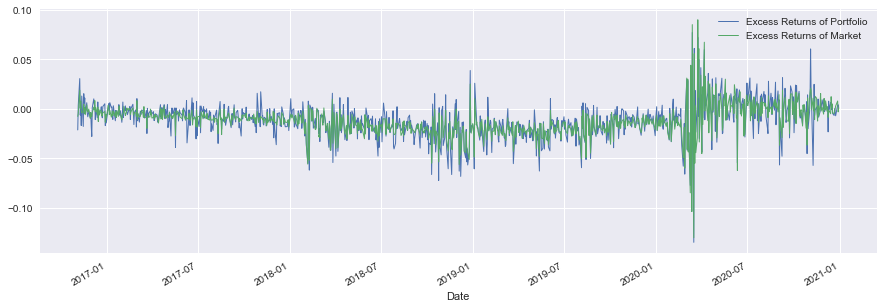

In [12]:
regressionData.plot();

In [13]:

X = sm.add_constant(regressionData["Excess Returns of Market"].values)
Y = regressionData["Excess Returns of Portfolio"].values
result = sm.OLS(Y, X, hasconst=True).fit()


In [14]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     4350.
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:15:25   Log-Likelihood:                 3586.0
No. Observations:                1046   AIC:                            -7168.
Df Residuals:                    1044   BIC:                            -7158.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      4.037      0.000       0.001       0.002
x1             1.0472      0.016     65.951      0.000       1.016       1.078
==============================================================================
Omnibus:                      228.102   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2322.303
Skew:                          -0.690   Prob(JB):                         0.00
Kurtosis:                      10.168   Cond. No.                         65.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:

jensenAlpha = result.params[0]
print("\n ------- CONGRATULATIONS ! ! ---------\n")
print("Your Portfolio has a Jensen Alpha of {}".format(round(jensenAlpha, 6)))



 ------- CONGRATULATIONS ! ! ---------

Your Portfolio has a Jensen Alpha of 0.001249
